# 1. Dane i modele klasyczne

In [15]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

In [16]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target
feature_names = diabetes.feature_names

print("Wiersze, kolumny:", X.shape)
print("Cechy:", feature_names)

Wiersze, kolumny: (442, 10)
Cechy: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


In [17]:
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
print(df.head())



        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0  


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=1.0)
}

In [19]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "model": model,
        "R2": r2_score(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred)
    }

print("\nWYNIKI MODELI:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"R2:  {metrics['R2']:.4f}")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")


WYNIKI MODELI:

Linear:
R2:  0.4526
MSE: 2900.1936
MAE: 42.7941

Ridge:
R2:  0.4192
MSE: 3077.4159
MAE: 46.1389

Lasso:
R2:  0.3576
MSE: 3403.5757
MAE: 49.7303


# 2. Wizualizacja

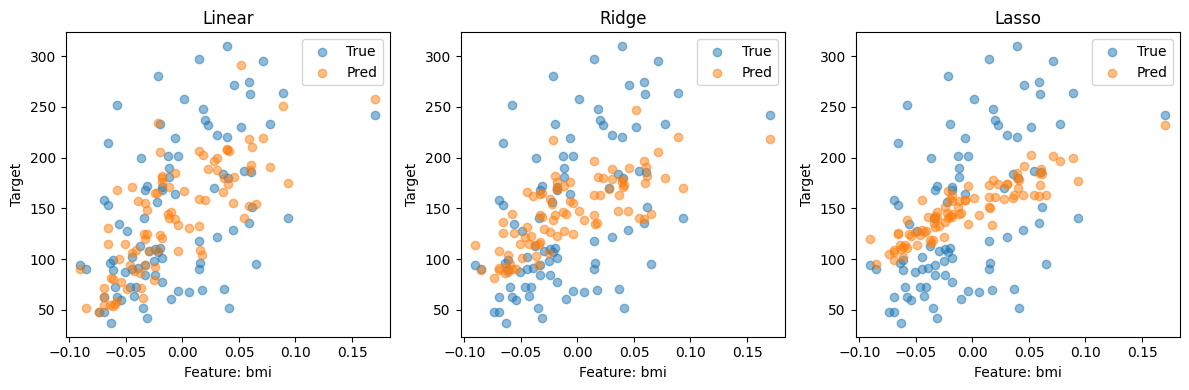

In [20]:
feature_idx = 2
feature_name = feature_names[feature_idx]

X_vis = X_test[:, feature_idx].reshape(-1, 1)

plt.figure(figsize=(12, 4))

for i, (name, metrics) in enumerate(results.items(), 1):
    model = metrics["model"]

    plt.subplot(1, 3, i)

    plt.scatter(X_vis, y_test, alpha=0.5, label='True')

    y_pred_vis = model.predict(X_test)
    plt.scatter(X_vis, y_pred_vis, alpha=0.5, label='Pred')

    plt.xlabel(f'Feature: {feature_name}')
    plt.ylabel('Target')
    plt.title(name)
    plt.legend()

plt.tight_layout()
plt.show()

# 3. Ważność cech


Ważność cech: [ 45.36737726  76.66608563 291.33883165 198.99581745   0.53030959
  28.57704987 144.51190505 119.26006559 230.22160832 112.14983004]


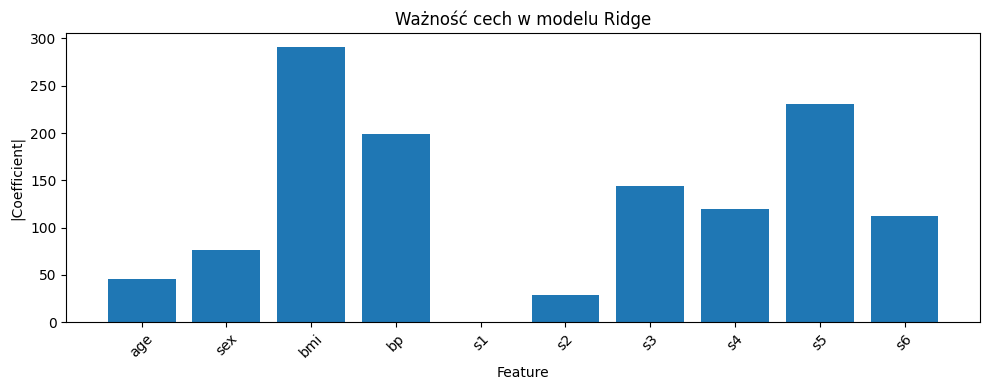

In [21]:
ridge = results['Ridge']['model']

feature_importance = np.abs(ridge.coef_)

print("\nWażność cech:", feature_importance)

plt.figure(figsize=(10, 4))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(range(len(feature_importance)), feature_names, rotation=45)
plt.xlabel('Feature')
plt.ylabel('|Coefficient|')
plt.title('Ważność cech w modelu Ridge')
plt.tight_layout()
plt.show()

# 4. Analiza reszt

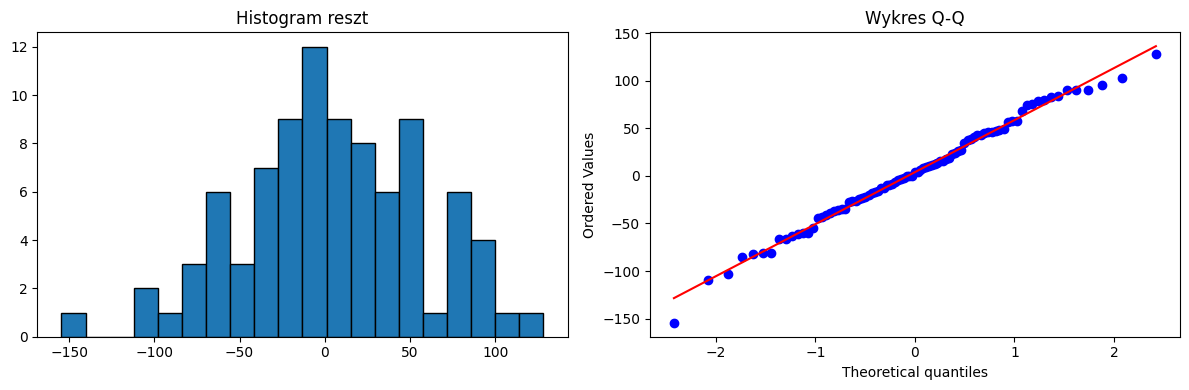

Shapiro-Wilk: stat=0.9927, p=0.9066 -> normalność OK
Durbin-Watson: 2.2428


In [22]:
linear_model = results['Linear']['model']
y_pred_lin = linear_model.predict(X_test)
residuals = y_test - y_pred_lin

plt.figure(figsize=(12, 4))

# Histogram reszt
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histogram reszt')

# wykres Q-Q
plt.subplot(1, 2, 2)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Wykres Q-Q')

plt.tight_layout()
plt.show()

# Shapiro-Wilk
stat, p = shapiro(residuals)

# Durbin-Watson
dw = durbin_watson(residuals)

print(f"Shapiro-Wilk: stat={stat:.4f}, p={p:.4f} -> {'normalność OK' if p>0.05 else 'odchylenie od normalności'}")
print(f"Durbin-Watson: {dw:.4f}")

# 5. Sieć neuronowa - Pytorch

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/200, Train Loss=0.3439, Val Loss=0.4716
Epoch 40/200, Train Loss=0.2113, Val Loss=0.5194
Epoch 60/200, Train Loss=0.1583, Val Loss=0.5502
Epoch 80/200, Train Loss=0.2007, Val Loss=0.6733
Epoch 100/200, Train Loss=0.1186, Val Loss=0.6686
Epoch 120/200, Train Loss=0.1019, Val Loss=0.6521
Epoch 140/200, Train Loss=0.0333, Val Loss=0.6324
Epoch 160/200, Train Loss=0.0304, Val Loss=0.6328
Epoch 180/200, Train Loss=0.0201, Val Loss=0.7033
Epoch 200/200, Train Loss=0.1056, Val Loss=0.6487

MAE sieci neuronowej: 0.5987


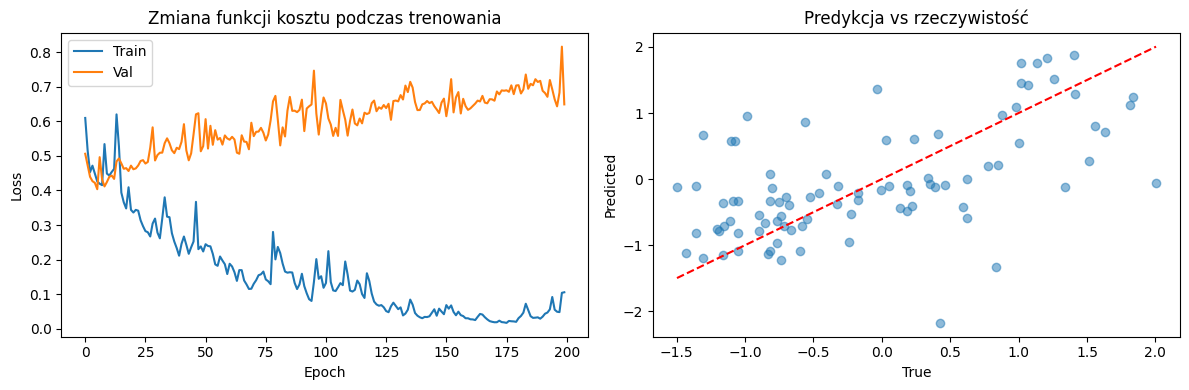

In [23]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)

X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# sieć neuronowa
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze()

model = RegressionNN(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# trenowanie
epochs = 200
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor)

    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss.item())

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}")

# ewaluacja
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mae = torch.mean(torch.abs(predictions - y_test_tensor))
    print(f"\nMAE sieci neuronowej: {mae:.4f}")

# wizualizacja wyników
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Zmiana funkcji kosztu podczas trenowania')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(y_test_scaled, predictions.numpy(), alpha=0.5)
plt.plot([y_test_scaled.min(), y_test_scaled.max()],
         [y_test_scaled.min(), y_test_scaled.max()], 'r--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Predykcja vs rzeczywistość')

plt.tight_layout()
plt.show()


# 6. Pojęcia

In [25]:
n_samples = len(X_train)
batch_size = 32
epochs = 200

iterations_per_epoch = int(np.ceil(n_samples / batch_size))
print(f"Próbek: {n_samples}, Batch: {batch_size}, Epok: {epochs}")
print(f"Iteracji/epoka: {iterations_per_epoch}")
print(f"Łącznie iteracji: {iterations_per_epoch * epochs}")


Próbek: 353, Batch: 32, Epok: 200
Iteracji/epoka: 12
Łącznie iteracji: 2400
